<h2>Met tjr les imports en haut

In [1]:
import os
from skimage import io
from skimage.transform import resize
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
import cv2
import matplotlib.pyplot as plt
import mahotas 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from skimage.feature import graycomatrix, graycoprops
import torch



<h3>la fonction qui va calculer la matrice de distance

In [2]:

def compute_distance_matrix(images, descriptor_function, feature_size=128):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    features = []
    for image in images:
        try:
            feature = descriptor_function(image)

            if isinstance(feature, np.float64) or np.isscalar(feature):
                feature = [feature]

            feature = np.array(feature)

            if feature.size < feature_size:
                feature = np.pad(feature, (0, feature_size - feature.size), mode='constant')
            elif feature.size > feature_size:
                feature = feature[:feature_size]

            features.append(feature)
        except Exception as e:
            print(f"Error processing image: {e}")
            features.append([0] * feature_size)

    features_tensor = torch.tensor(features, dtype=torch.float32, device=device)

    distance_matrix = torch.cdist(features_tensor, features_tensor, p=2)
    return distance_matrix


<h3>l'affichage de la matrice

In [3]:
def display_distance_matrix(distance_matrix, title):
    if isinstance(distance_matrix, torch.Tensor):
        distance_matrix = distance_matrix.cpu().numpy()
    plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()


<h3>Importer les image

In [4]:
food_directory = 'archive/training/food'
non_food_directory = 'archive/training/non_food'

food_image_paths = [os.path.join(food_directory, filename) for filename in os.listdir(food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
food_images = [io.imread(image_path) for image_path in food_image_paths]

non_food_image_paths = [os.path.join(non_food_directory, filename) for filename in os.listdir(non_food_directory) if filename.endswith('.png') or filename.endswith('.jpg')]
non_food_images = [io.imread(image_path) for image_path in non_food_image_paths]

image_paths = food_image_paths + non_food_image_paths
images = food_images + non_food_images


<h2>VOICI LA SQUELETTE DU CODE (peut etre modifiee)

In [7]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import timm
from transformers import ViTImageProcessor, ViTModel


def extract_inceptionV3_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge InceptionV3 pré-entraîné, en mode extraction de features
    model = timm.create_model('inception_v3', pretrained=True, features_only=True)
    model = model.eval().to(device)  # Mode évaluation et envoi sur GPU/CPU

    # Préprocessing adapté à InceptionV3
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((299, 299)),  # InceptionV3 attend une entrée de 299x299
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ])

    # Préparation de l'image
    img_tensor = preprocess(img).unsqueeze(0).to(device)  # Ajoute une dimension batch et envoie sur GPU/CPU

    # Extraction des features
    with torch.no_grad():
        features = model(img_tensor)[-1]  # On prend la dernière couche de features

    # Mise à plat des features pour obtenir un vecteur 1D
    feat = features.view(-1).cpu().numpy()  
    return feat

# Note : Pour un model plus grand, on peut remplacer "efficientnet_b0" par "efficientnet_b4"
def extract_efficientnet_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge un modèle EfficientNet pré-entraîné
    model = timm.create_model('efficientnet_b0', pretrained=True)
    model = model.eval()  # Mode évaluation
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Supprime la couche de classification
    model = model.to(device)  # Envoie le modèle sur GPU/CPU

    # Préprocessing de l'image adapté à EfficientNet
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((224, 224)),  # EfficientNet attend une entrée de 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ])

    # Préparation de l'image
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  # Ajoute une dimension batch
    img_tensor = img_tensor.to(device)  # Envoie l'image sur GPU/CPU

    # Extraction des features
    with torch.no_grad():
        features = model(img_tensor)

    # Mise à plat des features pour obtenir un vecteur 1D
    feat = features.view(-1).cpu().numpy()  
    return feat

# Note : on peut aussi tester avec "vit-large-patch32-384"
def extract_vit_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge le modèle ViT sans pooling + image processor
    model_name = "google/vit-base-patch16-224"
    processor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTModel.from_pretrained(model_name, add_pooling_layer=False).to(device)
    model.eval()  # Met en mode évaluation

    # Prétraitement de l’image avec ViTImageProcessor
    img_tensor = processor(images=img, return_tensors="pt")["pixel_values"].to(device)

    # Extraction des features
    with torch.no_grad():
        outputs = model(img_tensor)
        features = outputs.last_hidden_state  # Récupère les features de la dernière couche

    # Mise à plat des features en un vecteur 1D
    feat = features.view(-1).cpu().numpy()
    return feat

def extract_resnet101_features(img):
    # Vérifie si le GPU est disponible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Charge ResNet101 pré-entraîné
    model = models.resnet101(pretrained=True)
    model.fc = torch.nn.Identity()  # Supprime la dernière couche de classification
    model = model.eval().to(device)  # Mode évaluation et envoi sur GPU/CPU

    # Préprocessing de l'image adapté à ResNet
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((224, 224)),  # ResNet attend une entrée de 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
    ])

    # Préparation de l'image
    img_tensor = preprocess(img).unsqueeze(0).to(device)  # Ajoute une dimension batch et envoie sur GPU/CPU

    # Extraction des features
    with torch.no_grad():
        features = model(img_tensor)

    # Mise à plat des features en un vecteur 1D
    feat = features.view(-1).cpu().numpy()
    return feat

C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Antoine BOURGEOIS\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(mess

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


C:\Users\Antoine BOURGEOIS\AppData\Local\Temp\ipykernel_1596\2288914671.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


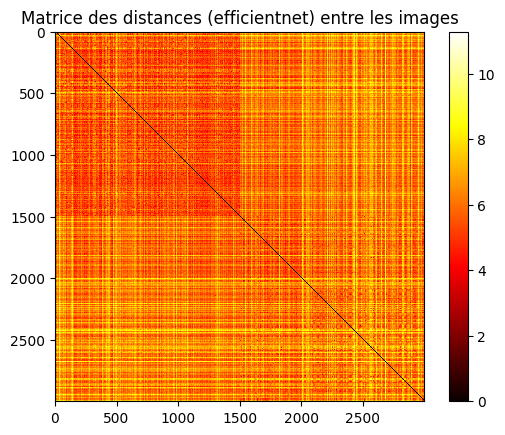

In [7]:
distance_matrix = compute_distance_matrix(images, extract_efficientnet_features)

display_distance_matrix(distance_matrix, "Matrice des distances (efficientnet) entre les images")

Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.
Error processing image: Invalid image shape. Expected either 4 or 3 dimensions, but got 2 dimensions.


C:\Users\Antoine BOURGEOIS\AppData\Local\Temp\ipykernel_5232\2288914671.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


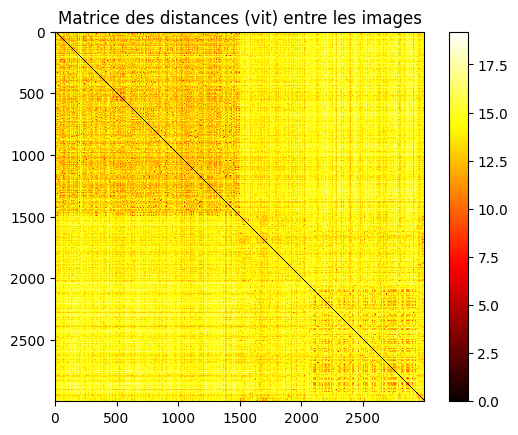

In [8]:
distance_matrix = compute_distance_matrix(images, extract_vit_features)

display_distance_matrix(distance_matrix, "Matrice des distances (vit) entre les images")

C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Antoine BOURGEOIS/.cache\torch\hub\checkpoints\resnet101-63fe2227.p

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


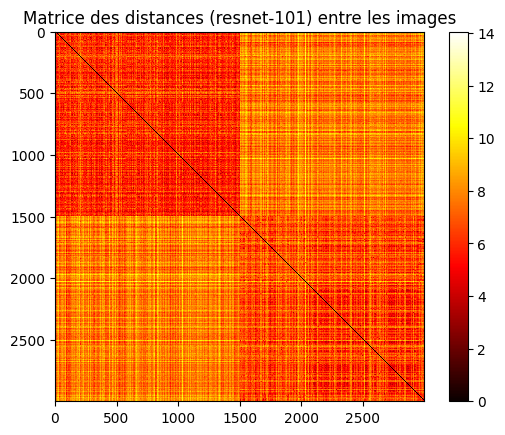

In [9]:
distance_matrix = compute_distance_matrix(images, extract_resnet101_features)

display_distance_matrix(distance_matrix, "Matrice des distances (resnet-101) entre les images")

C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Antoine BOURGEOIS\.cache\huggingface\hub\models--timm--inception_v3.tv_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


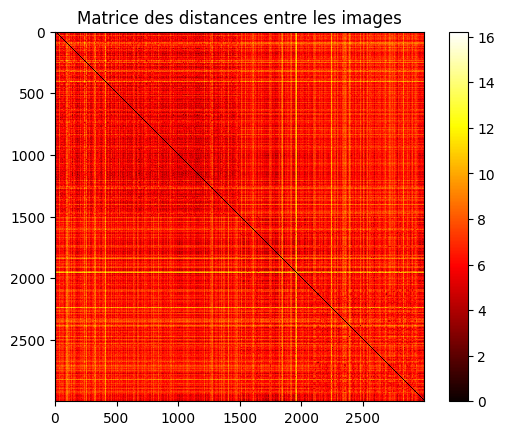

In [22]:
distance_matrix = compute_distance_matrix(images, extract_inceptionV3_features)

display_distance_matrix(distance_matrix, "Matrice des distances (inceptionV3) entre les images")

<H3>VOICI UN EXEMPLE POUR T'AIDER

In [18]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import numpy as np
import cv2

def extract_resnet50_features(img):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a pretrained ResNet-50 model
    model = resnet50(pretrained=True)
    model = model.eval()  
    model = torch.nn.Sequential(*list(model.children())[:-1]) 
    model = model.to(device)  

    preprocess = transforms.Compose([
        transforms.ToPILImage(),  
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])

    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)  
    img_tensor = img_tensor.to(device)  

    with torch.no_grad():
        features = model(img_tensor)

    feat = features.view(-1).cpu().numpy()  
    return feat


C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Antoine BOURGEOIS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Antoine BOURGEOIS/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
1

Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]
Error processing image: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


C:\Users\Antoine BOURGEOIS\AppData\Local\Temp\ipykernel_824\2288914671.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features_tensor = torch.tensor(features, dtype=torch.float32, device=device)


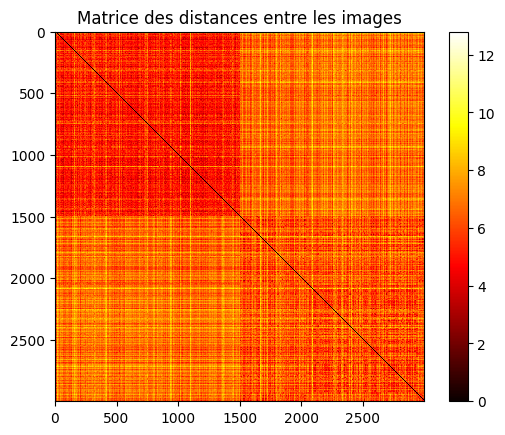

In [19]:
distance_matrix = compute_distance_matrix(images, extract_resnet50_features)

display_distance_matrix(distance_matrix, "Matrice des distances entre les images")


<h2> MAINTENANT A TOI DE JOUER</h2>
<h4>Tu dois chercher des models du computer vision ou deep learning qui sont deja pre entrainer, cette squelette peut ne pas marcher avec tout les models, si tu devras modifier le code d'un model ce n'est pas un probleme, tu peut jouer avec les paramettres pour auguementer la performence, tu dois savoir que chaque model a ces paramettres donc pas forcement de mettre les meme pour tt le monde.</h4>
<h4>les dfficultes que tu vas rencontrer sont de trouver d'abord des models, apres de choisir les bon paramettres, et enfin c'est que a chaque fois tu execute ca va prendre beacoups de temps</h4>
<h4>make sure to not reuse the same models that i have already used! 